# Example for processing a WDM signal with two polarisations
Here will be step by step example of processing a WDM signal with two polarisations.
You need just to run all cells in order.
There will be additional comments what is going on in each cell.

## Importing libraries and setting up the environment

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from importlib import reload

from prettytable import PrettyTable
from scipy.fft import fftshift, ifftshift, fft, ifft

import hpcom
from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter
from hpcom.channel import create_channel_parameters

from ssfm_gpu.propagation import propagate_manakov, dispersion_compensation_manakov
# from ssfm_gpu.propagation import propagate_schrodinger, dispersion_compensation
from ssfm_gpu.conversion import convert_forward, convert_inverse

import signal_handling.processing as prcs
import tools.functions as fn

import FNFTpy as fpy
import PJTpy as pjt

reload(prcs)
reload(hpcom)

from hpcom.signal import create_wdm_parameters, generate_wdm, get_points_wdm, receiver_wdm, nonlinear_shift, rrcosfilter

Allocate GPU memory

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-05-17 10:19:23.426301: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-17 10:19:23.429097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-17 10:19:23.475199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 10:19:23.475570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3070 Laptop GPU computeCapability: 8.6
coreClock: 1.56GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-05-17 10:19:23.475587: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-17 10:19:23.488160: I tensorflow/stream_executor/p

1 Physical GPUs, 1 Logical GPUs


## Setting up the parameters of signal and channel

In [8]:
wdm = create_wdm_parameters(n_channels=1,
                            p_ave_dbm=3,
                            n_symbols=2 ** 16,
                            m_order=16,
                            roll_off=0.1,
                            upsampling=4,
                            downsampling_rate=1,
                            symb_freq=34e9,
                            channel_spacing=75e9,
                            n_polarisations=2,
                            seed='fixed')

channel = create_channel_parameters(n_spans=12,
                                    z_span=80,
                                    alpha_db=0.0,
                                    gamma=1.2,
                                    noise_figure_db=-200,  # -200 means there is no noise
                                    dispersion_parameter=16.8,
                                    dz=1)

name_set = fn.form_name(wdm, channel)
print(name_set)

_16qam_34gbd_12spans_80km


In [9]:
signal_x, signal_y, wdm_info = generate_wdm(wdm)
points_x_orig = wdm_info['points_x'][0]
points_y_orig = wdm_info['points_y'][0]
# we can use only one filter_values because they are the same for both polarisations
ft_filter_values = wdm_info['ft_filter_values_x'][0] / wdm['upsampling']  # [0] index for only one WDM channel

2023-05-17 10:24:18.434866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2023-05-17 10:26:04.790835: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [10]:
start_time = datetime.now()
signal_x_prop, signal_y_prop = propagate_manakov(channel, signal_x, signal_y, sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

propagation took 1876.093 ms


In [11]:
signal_x_cdc, signal_y_cdc = dispersion_compensation_manakov(channel, signal_x_prop, signal_y_prop, 1. / wdm['sample_freq'])

points_x_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_x_cdc, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_cdc)
print(shift_factor_x, np.absolute(shift_factor_x))

points_y_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_y_cdc, ft_filter_values)[::wdm['downsampling_rate']], wdm) # downsample
shift_factor_y = np.dot(np.transpose(np.conjugate(points_y_orig)), points_y_orig) / np.dot(np.transpose(np.conjugate(points_y_orig)), points_y_cdc)
print(shift_factor_y, np.absolute(shift_factor_y))

(-1.0740369227322135-0.08619169401015454j) 1.077489823389726
(-1.0748469295590906-0.08275643047674826j) 1.0780280834782818


In [12]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
process_parameters['n_symb_proc'] = 16
process_parameters['n_symb_side'] = 256
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

In [13]:
# create array to store all recovered points
points_x_all = np.array([])
points_x_all_nft = np.array([])

## Signal windowing
<a id='signal_windowing'></a>

In [14]:
# cut the Tx and Rx signals to the size of the window
signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal((signal_x_prop, signal_y_prop), signal_parameters=wdm, process_parameters=process_parameters, channel=channel)
signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal((signal_x, signal_y), signal_parameters=wdm, process_parameters=process_parameters, channel=channel)

# both signal_windowed_cdc and signal_tx_windowed_cdc are tuples and have [0] - x polarisation, [1] - y polarisation

## NFT processing

Convert signal to dimensionless form

In [15]:
convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                 channel['beta2'],
                                 channel['gamma'],
                                 t0=1. / wdm['symb_freq'], type='manakov')

q_x_windowed_cdc = convert_result['q1']
q_y_windowed_cdc = convert_result['q2']
t_dl_window_cdc = convert_result['t']
dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
z_span_dimless = convert_result['z'] * 2  # TODO: change it for new version of ssfm_gpu
z_dimless = z_span_dimless * channel['n_spans']

Arrange parameters for the transformation

In [16]:
t = (np.arange(len(signal_x_prop)) - len(signal_x_prop) / 2) / wdm['sample_freq']
n_t = len(t_dl_window_cdc)
t_span = t[-1] - t[0]

# shift time to shift signal in the center of the time interval
t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2

# arrange nonlinear frequency grid \xi
xi_upsampling = 4
n_xi = xi_upsampling * n_t
rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)

Forward and inverse NFT

In [17]:
# Forward NFT
# types can be found in nft_handling/auxiliary.py:
# - 0 = 2SPLIT2_MODAL,
# - 4 = 2SPLIT2A,
# - 11 = 2SPLIT4B,
# - 42 = TES4_5B,
# - 50 = TES4_SUZUKI_B
# by default fnft_type = 11 and inv_fnft_type = 0

fnft_type = 42
inv_fnft_type = 0

q_fnft = []

for q_process in [q_x_windowed_cdc, q_y_windowed_cdc]:
    start_time = datetime.now()
    result_nlse = fpy.nsev(q_process, t_for_nft, xi[0], xi[-1], n_xi, dst=3, cst=2, dis=fnft_type, K=2048, display_c_msg=True)
    print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
    start_time = datetime.now()
    result_pjt = pjt.pjt(q_process, t_for_nft, contSpec=None, omp_num_threads=4, display_c_msg=True)
    # result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
    print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

    # Nonlinear spectrum evolution
    a = result_nlse['cont_a']
    b = result_nlse['cont_b']
    r = result_nlse['cont_ref']

    res = result_pjt

    rd = res['disc_res']
    bd = res['disc_norm']
    xi_d = res['bound_states']
    # ad = bd / rd

    b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
    bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))

    # Inverse NFT
    start_time = datetime.now()
    result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop,
                                           dis=inv_fnft_type, cst=1, dst=0)
    print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
    q_fnft.append(result_nsev_inverse['q'])

forward NFT took 211.504 ms
PJT took 5321.5070000000005 ms
inverse NFT took 1352.1680000000001 ms
forward NFT took 218.20000000000002 ms
ERASING2 (0.457663,0.00191748)
PJT took 5045.021000000001 ms
inverse NFT took 1283.314 ms


Inverse conversion from dimensionless form

In [18]:
convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                         channel['beta2'],
                                         channel['gamma'],
                                         t0=1. / wdm['symb_freq'], type='manakov')

signal_x_nft = convert_forward_result['Q1']
signal_y_nft = convert_forward_result['Q2']
t_nft = convert_forward_result['T']

Decode constellation points

In [19]:
# add zeros to the end of the signal to process with the same length as the original signal
n_signal_total = len(signal_x_prop)
signal_x_nft_complete = np.concatenate([signal_x_nft, np.zeros(n_signal_total - len(signal_x_nft))])
signal_x_nft_complete = tf.cast(signal_x_nft_complete, tf.complex128)

points_x_nft = get_points_wdm(hpcom.signal.filter_shaper(signal_x_nft_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm)

# for NFT processed we have n_symb_add + n_symb_side points from left
n_points_start_nft = int(process_parameters['n_symb_side'] + process_parameters['n_symb_add'])
n_points_end_nft = int(n_points_start_nft + process_parameters['n_symb_proc'])  # restore n_symb_proc points
range_points_nft = range(n_points_start_nft, n_points_end_nft)

# for original signal we have n_symb_skip + n_symb_side points from left
n_points_start_orig = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
n_points_end_orig = int(n_points_start_orig + process_parameters['n_symb_proc'])  # restore n_symb_proc points
range_points_orig = range(n_points_start_orig, n_points_end_orig)

# points_found = scale_p * points_x_window[range_points]
points_x_found_nft = points_x_nft[range_points_nft]
points_x_was_orig = points_x_orig[range_points_orig]

# shift and rotate points, if needed
shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_x_was_orig)), points_x_was_orig) / np.dot(
    np.transpose(np.conjugate(points_x_was_orig)), points_x_found_nft)
points_x_found_nft *= shift_factor_x_nft
print("shift factor for x:", shift_factor_x_nft, np.absolute(shift_factor_x_nft))

shift factor for x: (0.6072384396711729-0.8238661932574186j) 1.023471556520625


In [20]:
table = PrettyTable()
for k in range(len(points_x_found_nft)):
    table.add_row(['{:.5f}'.format(points_x_was_orig[k]),
                   '{:.5f}'.format(points_x_found_nft[k])])

print(table)

+-------------------+-------------------+
|      Field 1      |      Field 2      |
+-------------------+-------------------+
|  0.02996-0.02996j |  0.02982-0.02981j |
|  0.02996-0.00999j |  0.03521-0.00955j |
| -0.00999+0.02996j | -0.00786+0.03427j |
| -0.02996+0.02996j | -0.02829+0.02743j |
| -0.00999-0.02996j | -0.01434-0.03208j |
|  0.02996-0.02996j |  0.03037-0.03208j |
|  0.02996+0.02996j |  0.02937+0.02638j |
|  0.00999+0.02996j |  0.00648+0.03418j |
| -0.00999+0.00999j | -0.00838+0.00786j |
| -0.00999+0.00999j | -0.01300+0.00468j |
| -0.00999-0.02996j | -0.00193-0.03244j |
| -0.00999-0.00999j | -0.01338-0.00727j |
|  0.02996+0.02996j |  0.02740+0.02200j |
| -0.00999+0.00999j | -0.01327+0.00636j |
|  0.00999-0.00999j |  0.01333-0.01264j |
|  0.00999+0.02996j |  0.01313+0.03042j |
+-------------------+-------------------+


Now we can store points and continue signal processing

In [21]:
points_x_all = np.concatenate([points_x_all, points_x_was_orig])
points_x_all_nft = np.concatenate([points_x_all_nft, points_x_found_nft])

Now we can increment 'n_symb_skip' by 'n_symb_proc' and continue signal processing

In [22]:
process_parameters['n_symb_skip'] += process_parameters['n_symb_proc']

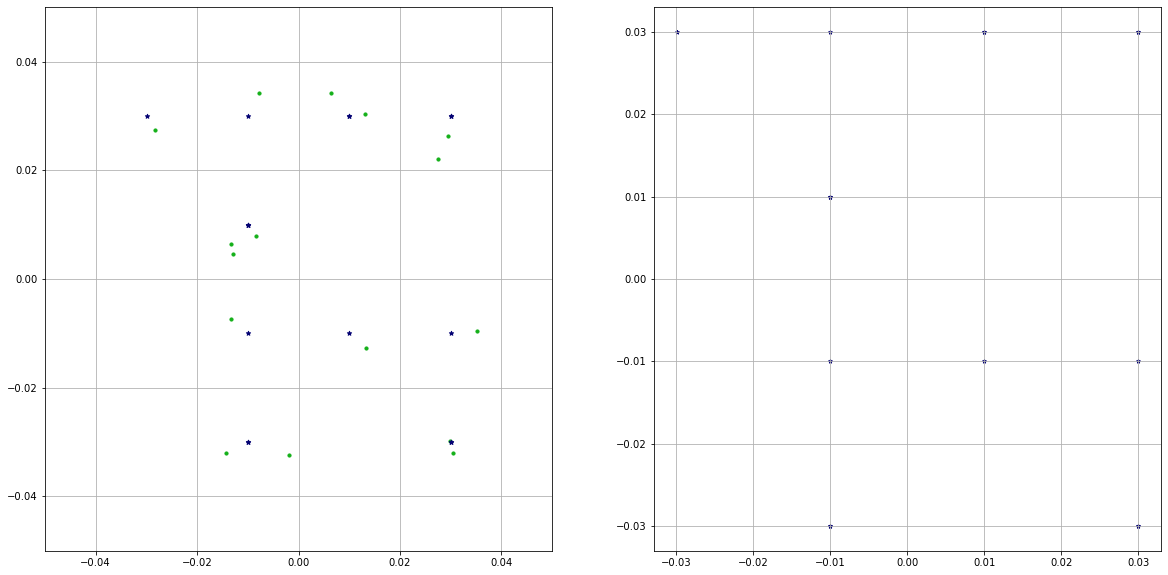

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_x_all_nft.real, points_x_all_nft.imag, s=10, c='xkcd:green', marker='o')
axs[0].scatter(points_x_all.real, points_x_all.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)
axs[0].set_xlim([-0.05, 0.05])
axs[0].set_ylim([-0.05, 0.05])

axs[1].scatter(points_x_all.real, points_x_all.imag, s=15, c='xkcd:deep blue', marker='*')
axs[1].grid(True)

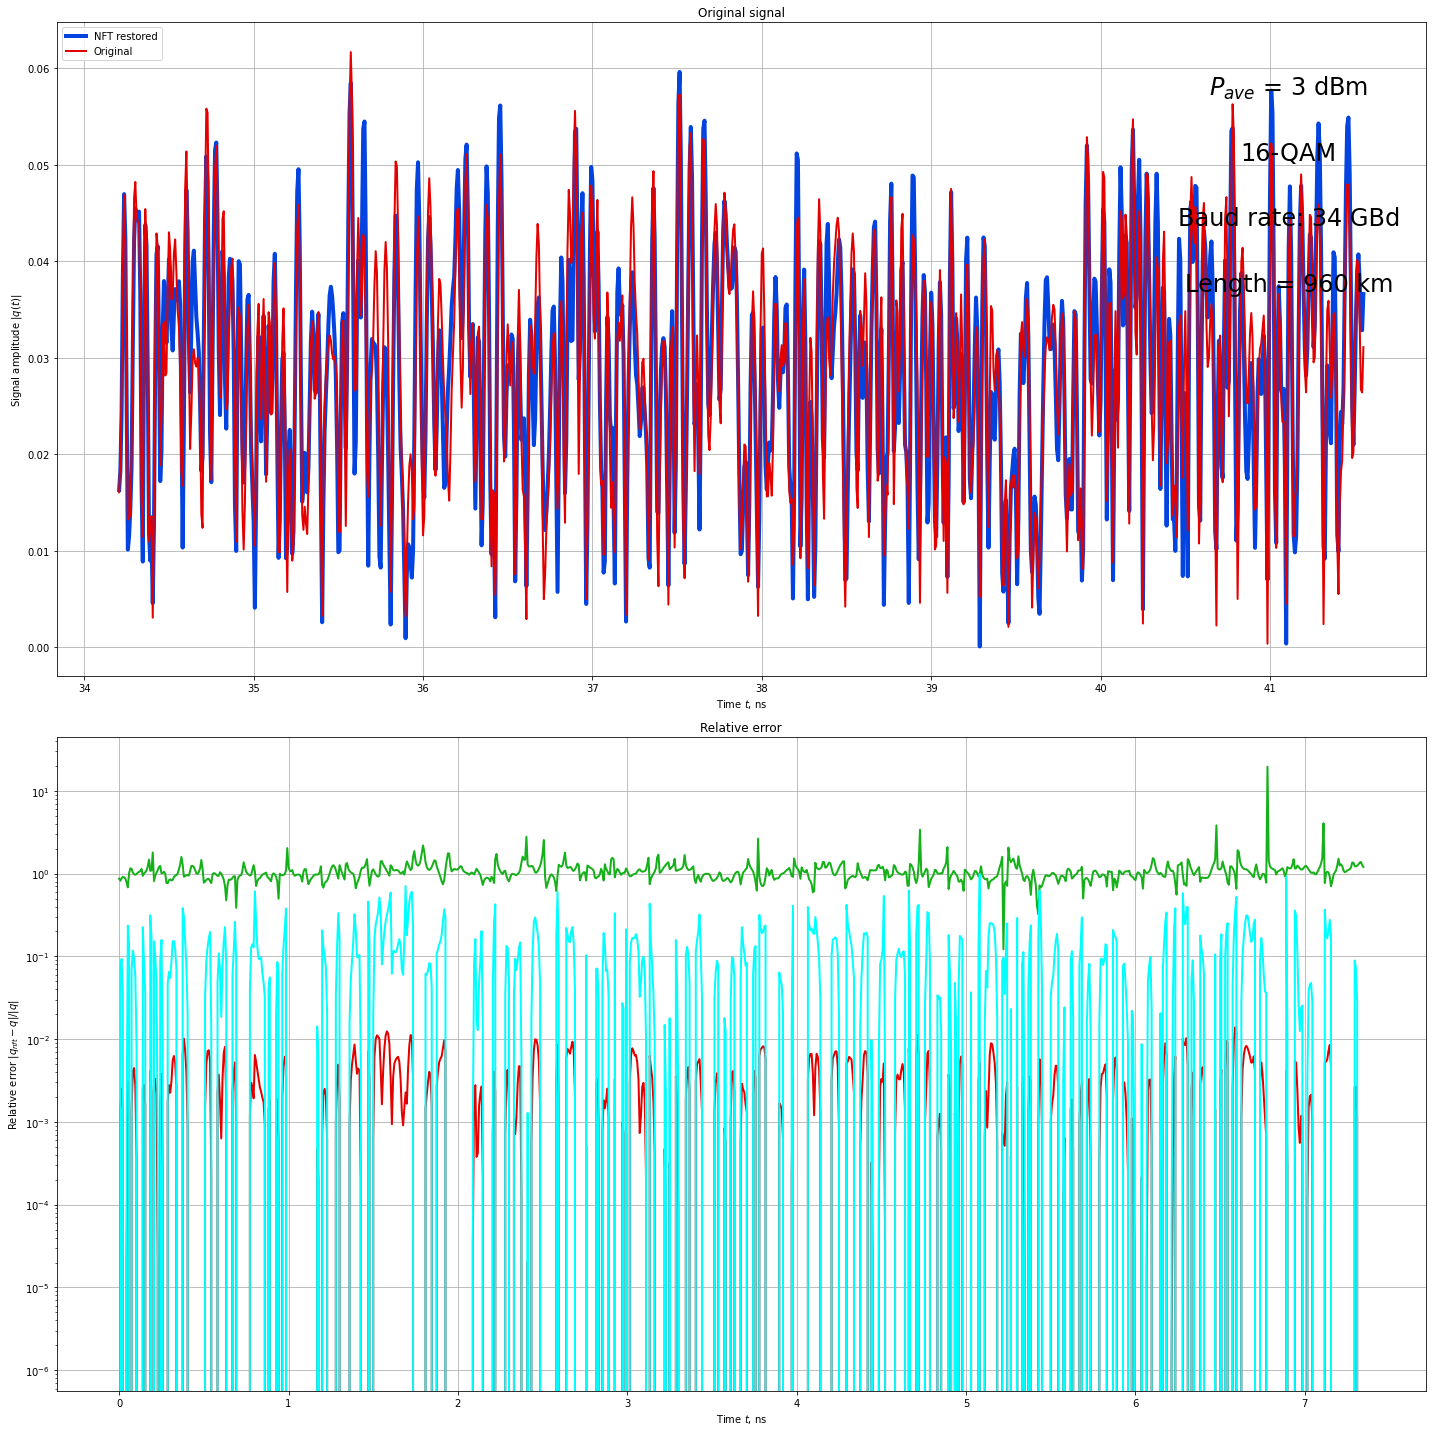

In [28]:
from matplotlib.gridspec import GridSpec
# matplotlib.rcParams.update({'font.size': 24})

# gs = GridSpec(nrows=3, ncols=1, height_ratios=[1, 1, 1])
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 1])

fig = plt.figure(figsize=(20, 20))

# Create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
# ax3 = fig.add_subplot(gs[2])

n_stp = 1000
stp = len(t_nft) // 2 - n_stp // 2
plot_range = range(stp, stp + n_stp)
# plot_range = range(800, len(t_nft)-800)

scale_for_time = 1e9

ax1.plot((t_nft[plot_range] - t[0])* scale_for_time, np.absolute(signal_x_nft[plot_range]), linewidth=4, color='xkcd:blue', label='NFT restored')
ax1.plot((t_tx_window_cdc[plot_range] - t[0])* scale_for_time, np.absolute(signal_tx_windowed_cdc[0][plot_range]), linewidth=2, color='xkcd:red', label='Original')
ax1.set_title(r'Original signal')
ax1.set_ylabel(r'Signal amplitude $|q(t)|$')
ax1.set_xlabel(r'Time $t$, ns')
ax1.grid(True)
ax1.legend(loc='upper left')
# ax1.xaxis.set_major_formatter(FuncFormatter(custom_sci_notation))
# ax1.set_xlim(t_tx_window_cdc[plot_range][0], t_tx_window_cdc[plot_range][-1])

ax1.text(0.9, 0.9, r'$P_{ave}$ = ' + str(wdm['p_ave_dbm']) + ' dBm',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)
ax1.text(0.9, 0.8, str(wdm['m_order']) + '-QAM',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)
ax1.text(0.9, 0.7, 'Baud rate: ' + str(int(wdm['symb_freq'] / 1e9)) + ' GBd',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)
ax1.text(0.9, 0.6, 'Length = ' + str(int(channel['n_spans'] * channel['z_span'])) + ' km',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes, fontsize=24)


ax2.plot((t_tx_window_cdc[plot_range] - t_tx_window_cdc[plot_range][0]) * scale_for_time, (np.absolute(signal_tx_windowed_cdc[0]-signal_x_nft)/np.absolute(signal_tx_windowed_cdc[0]))[plot_range], linewidth=2, color='xkcd:green')
ax2.plot((t_tx_window_cdc[plot_range] - t_tx_window_cdc[plot_range][0]) * scale_for_time, (np.absolute(signal_tx_windowed_cdc[0])-np.absolute(signal_x_nft))[plot_range], linewidth=2, color='xkcd:red')
ax2.plot((t_tx_window_cdc[plot_range] - t_tx_window_cdc[plot_range][0]) * scale_for_time, ((np.absolute(signal_tx_windowed_cdc[0])-np.absolute(signal_x_nft))/np.absolute(signal_tx_windowed_cdc[0]))[plot_range], linewidth=2, color='xkcd:cyan')
ax2.set_title(r'Relative error')
ax2.set_ylabel(r'Relative error $|q_{nft} - q|/|q|$')
ax2.set_xlabel(r'Time $t$, ns')
ax2.set_yscale('log')
ax2.grid(True)
# ax2.xaxis.set_major_formatter(FuncFormatter(custom_sci_notation))
# ax2.set_xlim(t_nft[plot_range][0], t_nft[plot_range][-1])


# ax3.plot(t_dl_window_cdc, np.absolute(q_windowed_cdc), linewidth=2, color='green')
# ax3.grid(True)

plt.tight_layout()

Go to [Signal windowing](#signal_windowing) section

# Here is the same example but with single function

In [64]:
def example_manakov_processing(wdm, channel, process_parameters):

    signal_x, signal_y, wdm_info = generate_wdm(wdm)
    points_x_orig = wdm_info['points_x'][0]
    points_y_orig = wdm_info['points_y'][0]

    # we can use only one filter_values because they are the same for both polarisations
    ft_filter_values = wdm_info['ft_filter_values_x'][0] / wdm['upsampling']  # [0] index for only one WDM channel
    start_time = datetime.now()
    signal_x_prop, signal_y_prop = propagate_manakov(channel, signal_x, signal_y,
                                                     sample_freq=int(wdm['symb_freq'] * wdm['upsampling']))
    print("propagation took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
    signal_x_cdc, signal_y_cdc = dispersion_compensation_manakov(channel, signal_x_prop, signal_y_prop,
                                                                 1. / wdm['sample_freq'])

    points_x_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_x_cdc, ft_filter_values)[::wdm['downsampling_rate']],
                                  wdm)  # downsample
    shift_factor_x = np.dot(np.transpose(np.conjugate(points_x_orig)), points_x_orig) / np.dot(
        np.transpose(np.conjugate(points_x_orig)), points_x_cdc)
    print(shift_factor_x, np.absolute(shift_factor_x))

    points_y_cdc = get_points_wdm(hpcom.signal.filter_shaper(signal_y_cdc, ft_filter_values)[::wdm['downsampling_rate']],
                                  wdm)  # downsample
    shift_factor_y = np.dot(np.transpose(np.conjugate(points_y_orig)), points_y_orig) / np.dot(
        np.transpose(np.conjugate(points_y_orig)), points_y_cdc)
    print(shift_factor_y, np.absolute(shift_factor_y))


    # create array to store all recovered points
    points_x_total = np.array([])
    points_x_total_nft = np.array([])


    for _ in range(process_parameters['n_steps']):
        print("Processing iteration", _, "of", process_parameters['n_steps'])  # print step number

        # Signal windowing
        # ----------------
        # cut the Tx and Rx signals to the size of the window
        signal_windowed_cdc, t_window_cdc = prcs.get_windowed_signal((signal_x_prop, signal_y_prop), signal_parameters=wdm,
                                                                     process_parameters=process_parameters, channel=channel)
        signal_tx_windowed_cdc, t_tx_window_cdc = prcs.get_windowed_signal((signal_x, signal_y), signal_parameters=wdm,
                                                                           process_parameters=process_parameters,
                                                                           channel=channel)
        # both signal_windowed_cdc and signal_tx_windowed_cdc are tuples and have [0] - x polarisation, [1] - y polarisation

        # Convert signal to dimensionless form
        # ------------------------------------
        convert_result = convert_inverse(signal_windowed_cdc, t_window_cdc, channel['z_span'],
                                         channel['beta2'],
                                         channel['gamma'],
                                         t0=1. / wdm['symb_freq'], type='manakov')

        q_x_windowed_cdc = convert_result['q1']
        q_y_windowed_cdc = convert_result['q2']
        t_dl_window_cdc = convert_result['t']
        dt_dl = t_dl_window_cdc[0] - t_dl_window_cdc[1]
        z_span_dimless = convert_result['z'] * 2  # TODO: change it for new version of ssfm_gpu
        z_dimless = z_span_dimless * channel['n_spans']


        # Arrange parameters for the transformation
        # -----------------------------------------
        t = (np.arange(len(signal_x_prop)) - len(signal_x_prop) / 2) / wdm['sample_freq']
        n_t = len(t_dl_window_cdc)
        t_span = t[-1] - t[0]

        # shift time to shift signal in the center of the time interval
        t_for_nft = t_dl_window_cdc - (t_dl_window_cdc[-1] + t_dl_window_cdc[0]) / 2

        # arrange nonlinear frequency grid \xi
        xi_upsampling = 4
        n_xi = xi_upsampling * n_t
        rv, xi_val = fpy.nsev_inverse_xi_wrapper(n_t, t_for_nft[0], t_for_nft[-1], n_xi)
        xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)


        # NFT
        # ---
        # types can be found in nft_handling/auxiliary.py:
        # - 0 = 2SPLIT2_MODAL,
        # - 4 = 2SPLIT2A,
        # - 11 = 2SPLIT4B,
        # - 42 = TES4_5B,
        # - 50 = TES4_SUZUKI_B
        # by default fnft_type = 11 and inv_fnft_type = 0

        fnft_type = 42
        inv_fnft_type = 0

        q_fnft = []

        for q_process in [q_x_windowed_cdc, q_y_windowed_cdc]:

            # Forward NFT
            # -----------
            start_time = datetime.now()
            result_nlse = fpy.nsev(q_process, t_for_nft, xi[0], xi[-1], n_xi, dst=3, cst=2, dis=fnft_type, K=2048,
                                   display_c_msg=True)
            print("forward NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
            start_time = datetime.now()
            result_pjt = pjt.pjt(q_process, t_for_nft, contSpec=None, omp_num_threads=4, display_c_msg=True)
            # result_pjt = pjt.pjt(q_windowed_cdc, t_for_nft, contSpec=np.concatenate([xi, result_nlse['cont_a']]), omp_num_threads=4, display_c_msg=True)
            print("PJT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")

            # Nonlinear spectrum evolution
            # ----------------------------
            a = result_nlse['cont_a']
            b = result_nlse['cont_b']
            r = result_nlse['cont_ref']

            res = result_pjt

            rd = res['disc_res']
            bd = res['disc_norm']
            xi_d = res['bound_states']
            # ad = bd / rd

            b_prop = b * np.exp(-2. * 1.0j * z_dimless * np.power(xi, 2))
            bd_prop = bd * np.exp(-2. * 1.0j * z_dimless * np.power(xi_d, 2))

            # Inverse NFT
            # -----------
            start_time = datetime.now()
            result_nsev_inverse = fpy.nsev_inverse(xi, t_for_nft, b_prop, xi_d, bd_prop,
                                                   dis=inv_fnft_type, cst=1, dst=0)
            print("inverse NFT took", (datetime.now() - start_time).total_seconds() * 1000, "ms")
            q_fnft.append(result_nsev_inverse['q'])


        # Inverse conversion from dimensionless form
        # ------------------------------------------
        convert_forward_result = convert_forward(q_fnft, t_dl_window_cdc, z_span_dimless,
                                                 channel['beta2'],
                                                 channel['gamma'],
                                                 t0=1. / wdm['symb_freq'], type='manakov')

        signal_x_nft = convert_forward_result['Q1']
        signal_y_nft = convert_forward_result['Q2']
        t_nft = convert_forward_result['T']


        # Decode constellation points
        # ---------------------------
        # add zeros to the end of the signal to process with the same length as the original signal
        n_signal_total = len(signal_x_prop)
        signal_x_nft_complete = np.concatenate([signal_x_nft, np.zeros(n_signal_total - len(signal_x_nft))])
        signal_x_nft_complete = tf.cast(signal_x_nft_complete, tf.complex128)

        points_x_nft = get_points_wdm(
            hpcom.signal.filter_shaper(signal_x_nft_complete, ft_filter_values)[::wdm['downsampling_rate']], wdm)

        # for NFT processed we have n_symb_add + n_symb_side points from left
        n_points_start_nft = int(process_parameters['n_symb_side'] + process_parameters['n_symb_add'])
        n_points_end_nft = int(n_points_start_nft + process_parameters['n_symb_proc'])  # restore n_symb_proc points
        range_points_nft = range(n_points_start_nft, n_points_end_nft)

        # for original signal we have n_symb_skip + n_symb_side points from left
        n_points_start_orig = int((process_parameters['n_symb_skip'] + process_parameters['n_symb_side']))
        n_points_end_orig = int(n_points_start_orig + process_parameters['n_symb_proc'])  # restore n_symb_proc points
        range_points_orig = range(n_points_start_orig, n_points_end_orig)

        # points_found = scale_p * points_x_window[range_points]
        points_x_found_nft = points_x_nft[range_points_nft]
        points_x_was_orig = points_x_orig[range_points_orig]

        # shift and rotate points, if needed
        shift_factor_x_nft = np.dot(np.transpose(np.conjugate(points_x_was_orig)), points_x_was_orig) / np.dot(
            np.transpose(np.conjugate(points_x_was_orig)), points_x_found_nft)
        points_x_found_nft *= shift_factor_x_nft
        print("shift factor for x:", shift_factor_x_nft, np.absolute(shift_factor_x_nft))


        # Now we can store points and continue signal processing
        # ------------------------------------------------------
        points_x_total = np.concatenate([points_x_total, points_x_was_orig])
        points_x_total_nft = np.concatenate([points_x_total_nft, points_x_found_nft])


        # Now we can increment 'n_symb_skip' by 'n_symb_proc' and continue signal processing
        process_parameters['n_symb_skip'] += process_parameters['n_symb_proc']


    return points_x_total, points_x_total_nft

In [68]:
process_parameters = prcs.get_default_process_parameters()
process_parameters['window_mode'] = 'cdc'
process_parameters['n_steps'] = 256
process_parameters['n_symb_proc'] = 16
process_parameters['n_symb_side'] = 300
process_parameters['n_symb_total'] = process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side']
process_parameters['n_symb_skip'] = 1024
process_parameters['n_symb_add'] = fn.side_to_np2(process_parameters['n_symb_proc'] + 2 * process_parameters['n_symb_side'])  # add to total number of symbols to make it power of 2

points_x_total, points_x_total_nft = example_manakov_processing(wdm, channel, process_parameters)

propagation took 1834.92 ms
(-1.0740369227322135-0.08619169401015454j) 1.077489823389726
(-1.0748469295590906-0.08275643047674826j) 1.0780280834782818
Processing iteration 0 of 256
forward NFT took 211.293 ms
PJT took 6062.715 ms
inverse NFT took 1711.048 ms
forward NFT took 216.51999999999998 ms
PJT took 6755.969 ms
inverse NFT took 1788.6109999999999 ms
shift factor for x: (0.5681177789014974-0.8566303904951916j) 1.0278975808045834
Processing iteration 1 of 256
forward NFT took 216.929 ms
PJT took 6240.219 ms
inverse NFT took 1876.182 ms
forward NFT took 212.79600000000002 ms
PJT took 6056.508 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1647.684 ms
shift factor for x: (0.5419993996647522-0.8466164880516317j) 1.0052476446517198
Processing iteration 2 of 256
forward NFT took 209.518 ms
PJT took 7106.99 ms
inverse NFT took 1664.4650000000001 ms
forward NFT took 221.67999999999998 ms
PJT took 6109.828 ms
inverse NFT took 1654.542 ms
shift factor for x: (0.6069583931397486-1.0583954350285454j) 1.2200817136126783
Processing iteration 3 of 256
forward NFT took 216.13 ms
PJT took 6649.273 ms
inverse NFT took 1697.276 ms
forward NFT took 231.356 ms
PJT took 6831.0779999999995 ms
inverse NFT took 1756.631 ms
shift factor for x: (0.47381905850114536-0.9446313331243215j) 1.0568031300668752
Processing iteration 4 of 256
forward NFT took 212.479 ms
PJT took 6339.610000000001 ms
inverse NFT took 1730.5269999999998 ms
forward NFT took 214.363 ms
PJT took 6221.439 ms
inverse NFT took 1640.4319999999998 ms
shift factor for x: (0.385727401366183-0.9425529629630218j) 1.0184260975422224
Processing iteration 5 of 256
forwa

FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1683.781 ms
shift factor for x: (0.6037470580030875-0.8509251413779061j) 1.043352340427908
Processing iteration 31 of 256
forward NFT took 213.013 ms
PJT took 5712.702 ms
inverse NFT took 1807.865 ms
forward NFT took 214.14 ms
PJT took 6782.095 ms
inverse NFT took 1661.9660000000001 ms
shift factor for x: (0.5350751431713204-0.8301313929227022j) 0.9876353266036988
Processing iteration 32 of 256
forward NFT took 209.316 ms
PJT took 5766.082 ms
inverse NFT took 1822.537 ms
forward NFT took 210.53 ms
PJT took 6194.320000000001 ms
inverse NFT took 1698.106 ms
shift factor for x: (0.5246263586988722-0.9276577312216225j) 1.065730586281958
Processing iteration 33 of 256
forward NFT took 207.298 ms
PJT took 5973.1050000000005 ms
inverse NFT took 1706.5300000000002 ms
forward NFT took 215.375 ms
PJT took 5496.8060000000005 ms
inverse NFT took 1757.15 ms
shift factor for x: (0.4476549958773651-0.979970013629182j) 1.0773746901363253
Processing iteration 34 of 256
forward NFT took

FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1652.303 ms
forward NFT took 216.29399999999998 ms
PJT took 5712.964999999999 ms
inverse NFT took 1702.7250000000001 ms
shift factor for x: (0.5570655338059387-0.8906155194855846j) 1.0504846560055379
Processing iteration 58 of 256
forward NFT took 214.274 ms
PJT took 5322.07 ms
inverse NFT took 1666.933 ms
forward NFT took 213.025 ms
PJT took 4977.769 ms
inverse NFT took 1709.228 ms
shift factor for x: (0.5212257777162955-0.9235127963179988j) 1.0604490540893734
Processing iteration 59 of 256
forward NFT took 211.168 ms
PJT took 5176.984 ms
inverse NFT took 1770.836 ms
forward NFT took 216.901 ms
PJT took 5288.8 ms
inverse NFT took 1728.194 ms
shift factor for x: (0.4505281415158165-0.9160228093555867j) 1.0208199613827098
Processing iteration 60 of 256
forward NFT took 214.031 ms
PJT took 5169.44 ms
inverse NFT took 1650.588 ms
forward NFT took 214.952 ms
PJT took 5085.901 ms
inverse NFT took 1737.044 ms
shift factor for x: (0.5069265174519585-0.9256812455815899j) 1.055

/home/esf0/anaconda3/envs/nn_env/lib/python3.9/site-packages/FNFTpy/auxiliary.py:159: UserWarning: An error occured when calling FNFT: error code -7
  warn(wstring)
FNFT Error: Sanity check failed (Bound_states should be simple (multiplicity should be 1).).
 in add_discrete_spectrum(755)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_inverse(239)-0.4.1


forward NFT took 214.004 ms
PJT took 5116.4310000000005 ms
inverse NFT took 1674.9019999999998 ms
shift factor for x: (-37.85626232325922+51.764953109120505j) 64.13039035805771
Processing iteration 63 of 256
forward NFT took 209.03900000000002 ms
PJT took 5466.418 ms
inverse NFT took 1677.6930000000002 ms
forward NFT took 211.475 ms
PJT took 4744.754999999999 ms
inverse NFT took 1701.794 ms
shift factor for x: (0.5681026355699597-0.8507545598518416j) 1.0229975198651438
Processing iteration 64 of 256
forward NFT took 217.66299999999998 ms
PJT took 5334.768999999999 ms
inverse NFT took 1631.95 ms
forward NFT took 213.951 ms
PJT took 5566.335 ms


FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1636.835 ms
shift factor for x: (0.5625772073359385-0.8370545634285856j) 1.0085402601634323
Processing iteration 65 of 256
forward NFT took 207.755 ms
PJT took 5333.406 ms
inverse NFT took 1759.789 ms
forward NFT took 212.344 ms
PJT took 5596.745 ms
inverse NFT took 1679.3039999999999 ms
shift factor for x: (0.5018468617428954-0.9090889969745553j) 1.0384089161122394
Processing iteration 66 of 256
forward NFT took 208.614 ms
ERASING2 (-1.04426,0.0341311)
PJT took 13808.439999999999 ms
inverse NFT took 1627.6399999999999 ms
forward NFT took 212.531 ms
PJT took 5030.160000000001 ms
inverse NFT took 1660.648 ms
shift factor for x: (0.5256504971335837-0.8986922444818425j) 1.0411321700094545
Processing iteration 67 of 256
forward NFT took 206.245 ms
ERASING2 (-0.0925757,0.00575243)
PJT took 5451.63 ms
inverse NFT took 1634.4840000000002 ms
forward NFT took 211.07899999999998 ms
ERASING2 (0.0200184,0.0318301)
PJT took 5390.991 ms
inverse NFT took 1685.89 ms
shift factor for x

FNFT Warning: Ill-posed spectral factorization problem.
 in fnft__poly_specfact(111)-0.4.1


inverse NFT took 1686.019 ms
shift factor for x: (0.42734969917338794-0.9241020600284929j) 1.018131810097538
Processing iteration 83 of 256
forward NFT took 211.175 ms
PJT took 5204.2789999999995 ms
inverse NFT took 1724.231 ms
forward NFT took 213.644 ms
PJT took 5471.474999999999 ms
inverse NFT took 1698.439 ms
shift factor for x: (0.4230607368497948-0.9150964229723783j) 1.0081576515608723
Processing iteration 84 of 256
forward NFT took 208.524 ms
PJT took 5382.67 ms
inverse NFT took 1760.715 ms
forward NFT took 214.021 ms
PJT took 5497.0160000000005 ms
inverse NFT took 1676.8529999999998 ms
shift factor for x: (0.5914517915383125-0.8220034868967674j) 1.0126721849563773
Processing iteration 85 of 256
forward NFT took 208.595 ms
PJT took 5361.642 ms
inverse NFT took 1657.0210000000002 ms
forward NFT took 214.255 ms
ERASING2 (0.785363,0.0387728)
PJT took 5694.414 ms
inverse NFT took 1716.397 ms
shift factor for x: (0.5764407370798398-0.7978438655398017j) 0.9842960718933313
Processing i

FNFT Error: Sanity check failed (Bound_states should be simple (multiplicity should be 1).).
 in add_discrete_spectrum(755)-0.4.1
FNFT Error: Subroutine failure.
 in fnft_nsev_inverse(239)-0.4.1


forward NFT took 213.82399999999998 ms
PJT took 6410.478 ms
inverse NFT took 1729.6670000000001 ms
shift factor for x: (-18.21805598577131-11.217327966088865j) 21.394532259423137
Processing iteration 148 of 256
forward NFT took 212.731 ms
ERASING2 (-0.368021,0.0405825)
PJT took 6415.8460000000005 ms
inverse NFT took 1713.4279999999999 ms
forward NFT took 212.992 ms
PJT took 5812.588 ms
inverse NFT took 1736.999 ms
shift factor for x: (0.5267426531387961-0.8846383218415088j) 1.0295837912021824
Processing iteration 149 of 256
forward NFT took 209.645 ms
PJT took 5202.794 ms
inverse NFT took 1676.9350000000002 ms
forward NFT took 214.388 ms
PJT took 6093.706 ms
inverse NFT took 1721.787 ms
shift factor for x: (0.4793373320724784-0.9202833232295877j) 1.0376346529163603
Processing iteration 150 of 256
forward NFT took 210.74300000000002 ms
PJT took 4944.4929999999995 ms
inverse NFT took 1641.301 ms
forward NFT took 216.07000000000002 ms
PJT took 6071.5779999999995 ms
inverse NFT took 1679.0

## Plot constellation points

In [72]:
mod_type = hpcom.modulation.get_modulation_type_from_order(wdm['m_order'])
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(wdm['p_ave'] / wdm['n_polarisations'])

points_x_found = hpcom.modulation.get_nearest_constellation_points_unscaled(points_x_total_nft, mod_type)
# points_y_found = hpcom.metrics.get_nearest_constellation_points_unscaled(points_y_total_nft, mod_type)

ber_x = hpcom.metrics.get_ber_by_points(points_x_total * scale_constellation, points_x_found, mod_type)
# ber_y = hpcom.metrics.get_ber_by_points(points_y_orig * scale_constellation, points_y_found, mod_type)

print(ber_x)

(0.25860595703125, 4237)


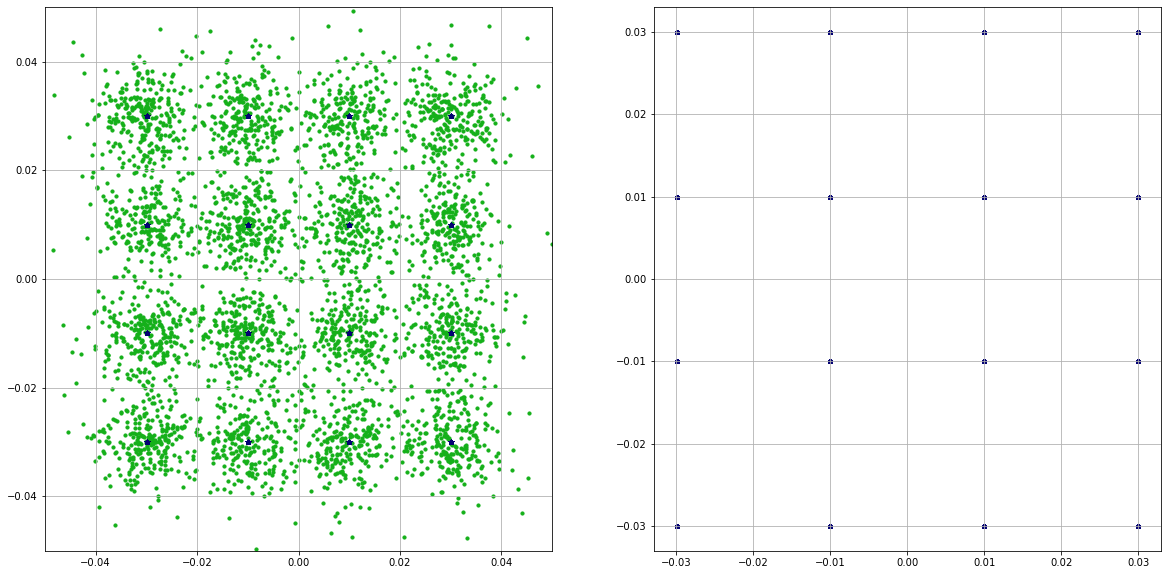

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].scatter(points_x_total_nft.real, points_x_total_nft.imag, s=10, c='xkcd:green', marker='o')
axs[0].scatter(points_x_total.real, points_x_total.imag, s=20, c='xkcd:deep blue', marker='*')
axs[0].grid(True)
axs[0].set_xlim([-0.05, 0.05])
axs[0].set_ylim([-0.05, 0.05])

axs[1].scatter(points_x_total.real, points_x_total.imag, s=15, c='xkcd:deep blue', marker='*')
axs[1].grid(True)